In [160]:
import yfinance as yf
import pandas as pd
import numpy as np

#getting data from yfinance
data = yf.download('EURUSD=X', start='2022-08-01', end='2024-08-01')
close = data['Close']

#DataFrame
df = pd.DataFrame(close)
df.reset_index(inplace=True)
print(df)

[*********************100%%**********************]  1 of 1 completed

          Date     Close
0   2022-08-01  1.020825
1   2022-08-02  1.026136
2   2022-08-03  1.015569
3   2022-08-04  1.015765
4   2022-08-05  1.024779
..         ...       ...
517 2024-07-25  1.083952
518 2024-07-26  1.085128
519 2024-07-29  1.085376
520 2024-07-30  1.081947
521 2024-07-31  1.081607

[522 rows x 2 columns]


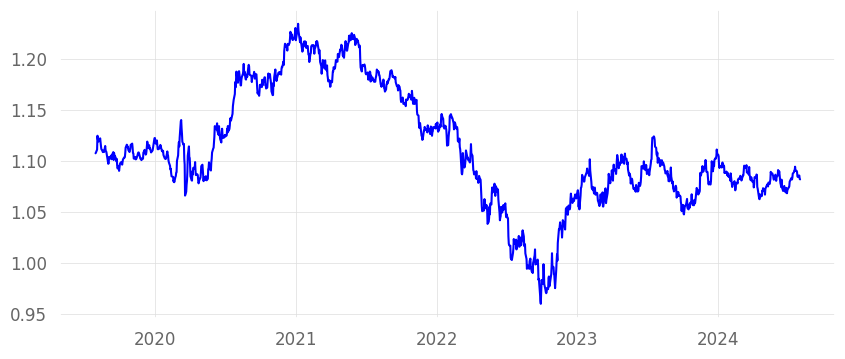

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df['Date'],df['Close'],color = 'blue')


# Split the data in sample and out of sample

In [150]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.15, shuffle=False)

train


,Date,Close
0,2019-08-01,1.107175
1,2019-08-02,1.107886
2,2019-08-05,1.110803
3,2019-08-06,1.124379
4,2019-08-07,1.120699
...,...,...
1103,2023-10-24,1.066985
1104,2023-10-25,1.059535
1105,2023-10-26,1.056725
1106,2023-10-27,1.056446


# Apply Seasonal trend decomposition aka STL on close prices using statsmodels

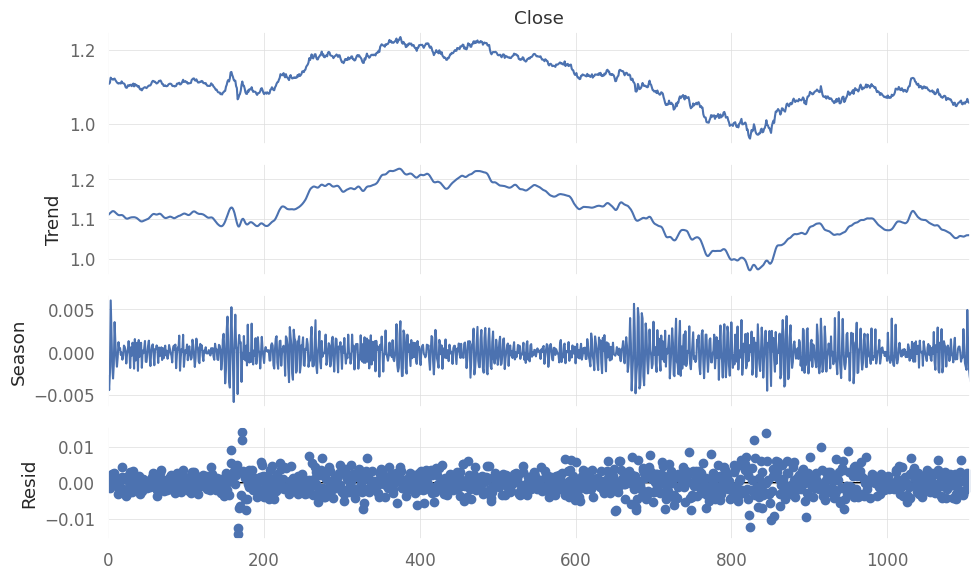

In [151]:
from statsmodels.tsa.seasonal import STL

stl = STL(train['Close'],period = 5)
result = stl.fit()

#visualisation
result.plot()
plt.show()

# visualisation of residual as histogram

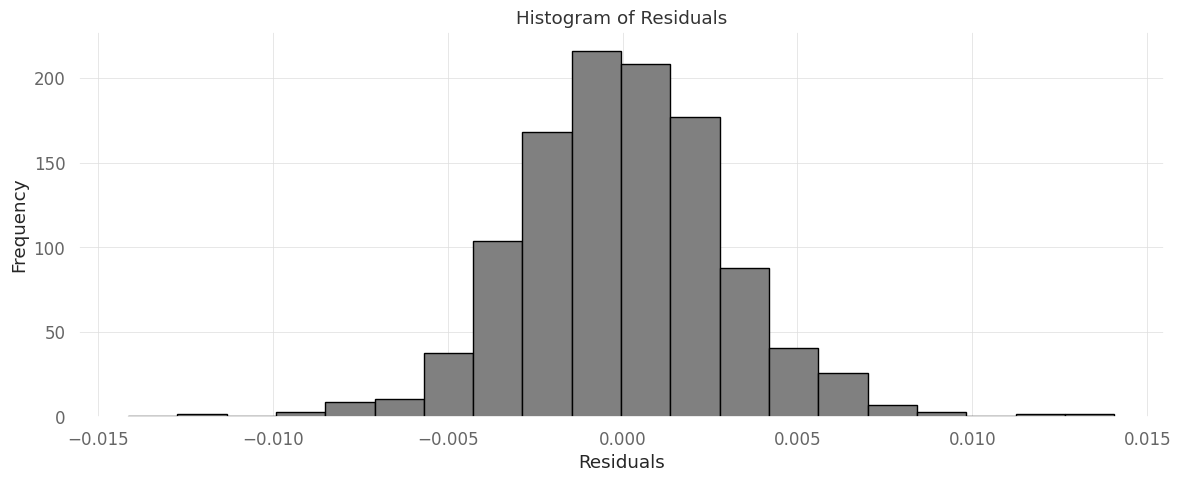

In [152]:
plt.figure(figsize=(14, 5))
plt.hist(result.resid, bins=20 ,color='gray', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

# finding thresholds

when the residual value  is higher than upthreshold so it's a signal of sell,and if it's lower than lowthreshold it's a signal of buy.

In [153]:
rs_mean = result.resid.mean()
rs_std = result.resid.std()
UPthreshold = rs_mean + 2 * rs_std
LOWthreshold = rs_mean - 2 * rs_std

# visualisation sell and buy signals

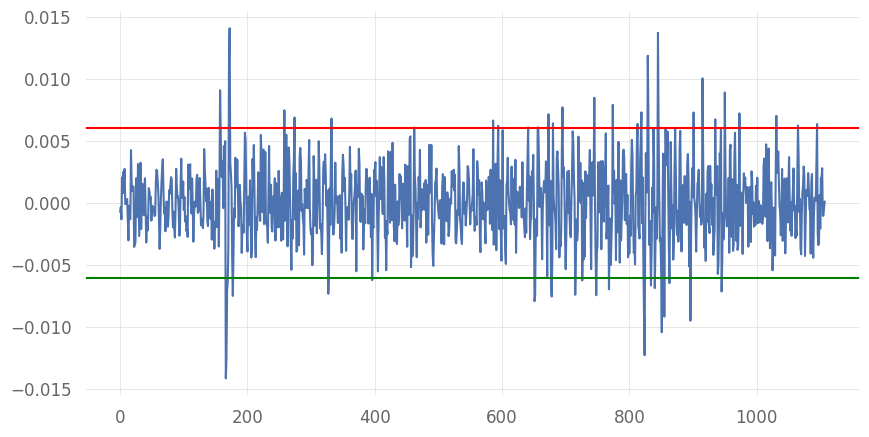

In [154]:
train['buy_signal'] = result.resid > UPthreshold
train['sell_signal'] = result.resid < LOWthreshold
plt.figure(figsize = (10,5))
plt.plot(train.index, result.resid)
plt.axhline(y=UPthreshold, color='red')
plt.axhline(y=LOWthreshold, color='green')


# simulation of the strategy 

In [155]:
position = 0 #(1 for long , -1 for short ,0 for no position)
cumul = 0
profits = []
positionprice = 0
train['Position'] = 0


for i in range(len(train)):
    if train['buy_signal'].iloc[i] and position != 1:
        position = 1
        positionprice = train['Close'].iloc[i]
        print(f"buy {positionprice} on {train['Date'].iloc[i]}")
    elif train['sell_signal'].iloc[i] and position != -1 :
        position = -1
        positionprice = train['Close'].iloc[i]
        print(f"sell {positionprice} on {train['Date'].iloc[i]}")


    if position == 1:
        train.at[i, 'Position'] = 1
        profit = train['Close'].iloc[i] - positionprice
    elif position == -1 :
        train.at[i, 'Position'] = -1
        profit = positionprice - train['Close'].iloc[i]
    else :
        profit = 0

    cumul = cumul + profit
    profits.append(cumul)


buy 1.1386020183563232 on 2020-03-09 00:00:00
sell 1.0657345056533813 on 2020-03-20 00:00:00
buy 1.1048258543014526 on 2020-03-27 00:00:00
sell 1.0806955099105835 on 2020-04-06 00:00:00
buy 1.1769275665283203 on 2020-07-28 00:00:00
sell 1.1642121076583862 on 2020-11-02 00:00:00
buy 1.1893010139465332 on 2020-11-09 00:00:00
sell 1.1966731548309326 on 2021-02-05 00:00:00
buy 1.2171076536178589 on 2021-05-10 00:00:00
sell 1.1147029399871826 on 2022-01-28 00:00:00
buy 1.14357590675354 on 2022-02-04 00:00:00
sell 1.087453007698059 on 2022-03-07 00:00:00
buy 1.107382893562317 on 2022-03-10 00:00:00
sell 1.0555092096328735 on 2022-04-28 00:00:00
buy 1.071765422821045 on 2022-06-09 00:00:00
sell 1.0415147542953491 on 2022-06-14 00:00:00
buy 1.0231330394744873 on 2022-07-20 00:00:00
sell 0.9623712301254272 on 2022-09-27 00:00:00
buy 0.998432457447052 on 2022-10-05 00:00:00
sell 0.9700167775154114 on 2022-10-12 00:00:00
buy 1.009193778038025 on 2022-10-27 00:00:00
sell 0.9749630093574524 on 2022

Text(0.5, 1.0, 'Cumulative Profit')

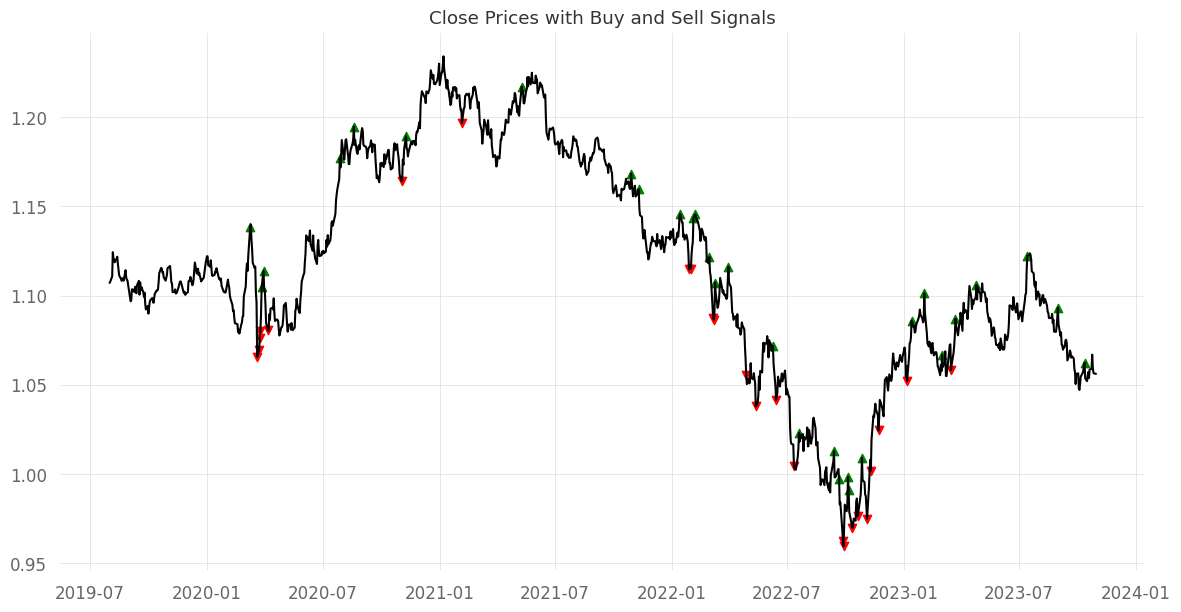

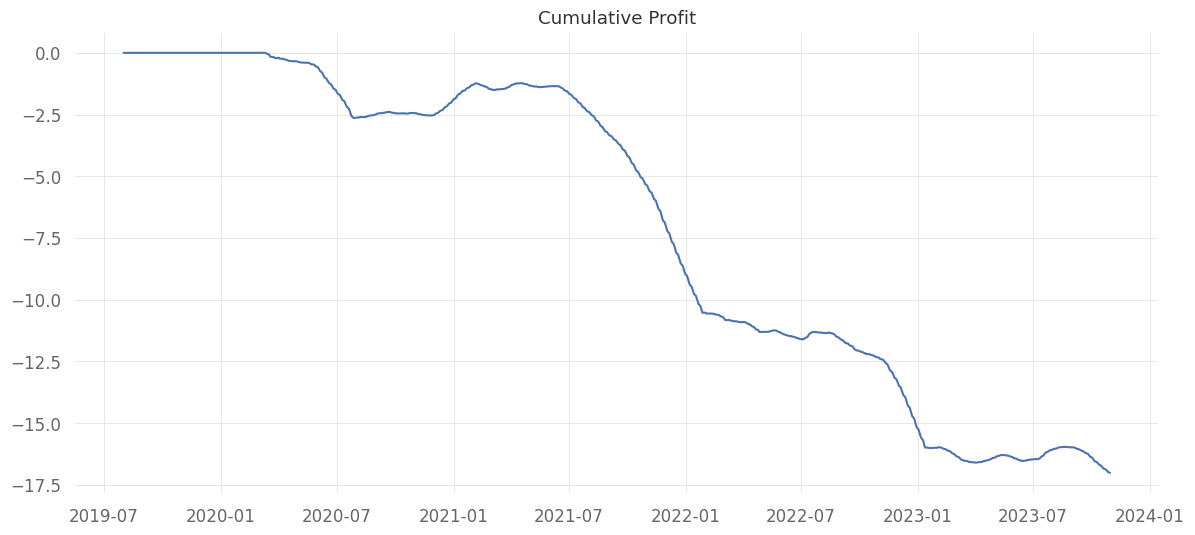

In [156]:
plt.figure(figsize=(14, 7))
plt.plot(train['Date'], train['Close'],label = 'Close price',color = 'black')
#isolate the true value of buy_signals and sell signals from the frame
buy_signals = train[train['buy_signal']]
sell_signals = train[train['sell_signal']]
#draw the marker that indicate the signal
plt.scatter(buy_signals['Date'],buy_signals['Close'],marker = '^',color = 'green')
plt.scatter(sell_signals['Date'],sell_signals['Close'],marker = 'v',color = 'red')
plt.title('Close Prices with Buy and Sell Signals')
# Cumulative Profit
plt.figure(figsize=(14,6))
plt.plot(train['Date'], profits, label='Cumulative Profit')
plt.title('Cumulative Profit')

# log returns

In [157]:
train['LogReturn'] = np.log(train['Close'] / train['Close'].shift(1))

<Axes: >

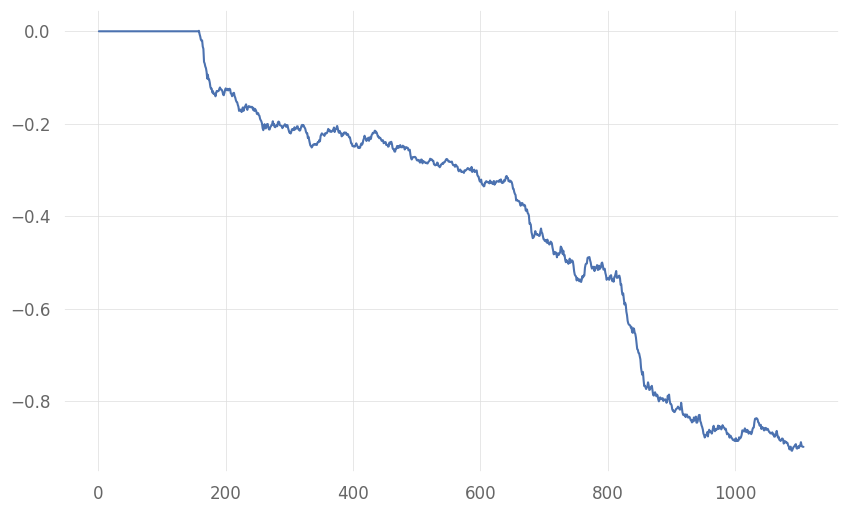

In [158]:
train['Strategy Return'] = train['LogReturn'] * train['Position'].shift(1)
train['Strategy Return'].cumsum().plot() #plot the cumulative of strategy return


# backtesting

In [159]:
import quantstats as qs
qs.extend_pandas()
train['Date'] = pd.to_datetime(train['Date'])
train.set_index('Date', inplace=True)
qs.reports.html(train['Strategy Return'], output='backtest_report.html')

/home/zaid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/zaid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/zaid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, 